# RBM(Restricted Boltzmann Machine)

# Author's Notes

May 2021 Update: Support for TensorFlow 2. Note that the results in this notebook differ from those in the book because of randomness in the seed we have set here vs. the original seed for TensorFlow and numpy in the book. This is expected. I encourage you to experiment on your own by changing the seed for TensorFlow and numpy in this notebook.

Note for Mac users: You will need to use the "tensorflow_mac" Conda environment for this notebook instead of the "unsupervisedLearning" Conda environment. Please refer to the README on the GitHub repo for more.

From [Hands-on Unsupervised Learning using Python](https://amzn.to/2tVABNx) - Chapter 10 - Recommender Systems Using Restricted Boltzmann Machines (RBMs)

# Google Colab Setup
**Only for users on Google Colab**

In [1]:
"""# Define functions to connect to Google and change directories
def connectDrive():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

def changeDirectory(path):
    import os
    original_path = os.getcwd()
    os.chdir(path)
    new_path = os.getcwd()
    print("Original path: ",original_path)
    print("New path: ",new_path)

# Connect to Google Drive
connectDrive()

# Change path
changeDirectory("/content/drive/My Drive/github/handson-unsupervised-learning/")"""

Mounted at /content/drive
Original path:  /content
New path:  /content/drive/My Drive/github/handson-unsupervised-learning


## Setup

In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime
from zipfile import ZipFile
from urllib.request import urlretrieve

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

/Users/jangseokhee/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Check library versions & set seed

In [4]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
# print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.2.2
tensorflow 2.15.0
numpy      1.26.2


In [5]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF, if GPU is available.")

Please install GPU version of TF, if GPU is available.


# Data Preparation

## MovieLens Dataset 

|MovieLens 20M Dataset||
|:------------|----------|
|ratings     |20,000,263| 
|movies      |27,278| 
|users       |138,493|

## Load the Data 

In [7]:
# Download and read into Pandas DataFrame
current_path = os.getcwd()
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-20m.zip", \
            current_path+"/datasets/movielens.zip")
ZipFile(current_path+"/datasets/movielens.zip", "r").extractall(current_path+"/datasets/")
ratingDF = pd.read_csv(current_path+"/datasets/ml-20m/ratings.csv")

In [8]:
# Convert fields into appropriate data types 
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                        datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [9]:
# Store DataFrame as pickle for faster loading in the future
ratingDF.to_pickle(current_path+"/datasets/ml-20m/ratingPickle")
ratingDF = pd.read_pickle(current_path+"/datasets/ml-20m/ratingPickle")

In [10]:
# Preview data
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [11]:
# Calculate summary statistics on full dataset
n_users = ratingDF.userId.unique().shape[0]
n_movies = ratingDF.movieId.unique().shape[0]
n_ratings = len(ratingDF)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 138493
Number of unique movies: 26744
Number of total ratings: 20000263
Average number of ratings per user: 144.4


In [12]:
# Reduce size of dataset by taking top 1000 movies
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= 
                "rating",ascending=False)[0:1000].index
ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [13]:
# Reduce size of dataset by sampling 1000 users
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= 
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

In [14]:
# Reindex movie ID
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies,columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index+1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [15]:
# Reindex user ID
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index+1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [16]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId',
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)
ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', 
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


In [17]:
# Save as pickle
pickle_file = os.path.sep.join(['', 'datasets', 'movielens_data', 'ratingReducedPickle'])
ratingDFX3.to_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")
ratingDFX3 = pd.read_pickle(current_path + "/datasets/ml-20m/ratingReducedPickle")

In [18]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print(f'Number of unique users: {n_users}')
print(f'Number of unique movies: {n_movies}')
print(f'Number of total ratings: {n_ratings}')
print(f'Average number of ratings per user: {round(avg_ratings_per_user,1)}')

Number of unique users: 1000
Number of unique movies: 1000
Number of total ratings: 90213
Average number of ratings per user: 90.2


In [19]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)
X_valid, X_test = train_test_split(X_test,     test_size=0.50, \
                                   shuffle=True, random_state=2018)

In [20]:
# Confirm size of train, validation, and test datasets
for (l,x) in [('train',X_train),('validation',X_valid),('test',X_test)]:
    print(f'Size of {l} set: {len(x)}')

Size of train set: 81191
Size of validation set: 4511
Size of test set: 4511


In [21]:
# Generate ratings matrix for train, validation and test
ratings_train = np.zeros((n_users, n_movies))
ratings_valid = np.zeros((n_users, n_movies))
ratings_test  = np.zeros((n_users, n_movies))
for (X,ratings) in [(X_train,ratings_train),(X_valid,ratings_valid),(X_test,ratings_test)]:
    for row in X.itertuples():
        ratings[row[6]-1, row[5]-1] = row[3]

In [22]:
ratings_train.shape, ratings_valid.shape, ratings_test.shape

((1000, 1000), (1000, 1000), (1000, 1000))

##### Define loss function: mean : mean square error

In [23]:
# Calculate the sparsity of the train, validation & test rating matrices
def calc_sparsity(label, ratings):
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    print('{:s} Sparsity: {:4.2f}%'.format(label, sparsity))

In [24]:
for (lbl, rtg) in [('Train',ratings_train),('Validation',ratings_valid),('Test', ratings_test)]:
    calc_sparsity(lbl,rtg)

Train Sparsity: 8.12%
Validation Sparsity: 0.45%
Test Sparsity: 0.45%


# Perform Baseline Experiments 

In [25]:
# Flatten the sprace matrix with the rations for the validation set. This will be the vector of actual ratings
actual_valid = ratings_valid[ratings_valid.nonzero()].flatten()

## Experiment One 
### Assign naive 3.5 rating and calculate baseline MSE

In [26]:
pred_valid = np.zeros((len(X_valid),1))
pred_valid[pred_valid==0] = 3.5

In [27]:
naive_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using naive prediction: {round(naive_prediction,2)}')

Mean squared error using naive prediction: 1.06


## Experiment Two
## Predict a user's rating based on user's average rating for all other movies

In [28]:
ratings_valid_pred = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()
user_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using user average: {round(user_average,3)}')

Mean squared error using user average: 0.909


## Experiment Three
### Predict a user's rating for a movie based on the average rating other users have given that movie 

In [29]:
ratings_valid_pred = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_valid_pred[i][ratings_valid_pred[i]==0] = np.mean(row[row>0])
    i += 1

ratings_valid_pred = ratings_valid_pred.T
pred_valid = ratings_valid_pred[ratings_valid.nonzero()].flatten()
movie_average = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using movie average: {round(movie_average,3)}')

Mean squared error using movie average: 0.914


# Matrix Factorization 

## Experiment Four - Recommender System using Matrix Factorization
### One Latent Factor

In [30]:
n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [31]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100


2538/2538 [==============================] - 1s 412us/step - loss: 13.6139 - val_loss: 11.8558
Epoch 2/100
2538/2538 [==============================] - 1s 387us/step - loss: 9.1302 - val_loss: 6.5461
Epoch 3/100
2538/2538 [==============================] - 1s 386us/step - loss: 4.6549 - val_loss: 3.3624
Epoch 4/100
2538/2538 [==============================] - 1s 397us/step - loss: 2.5642 - val_loss: 2.0671
Epoch 5/100
2538/2538 [==============================] - 1s 393us/step - loss: 1.6544 - val_loss: 1.4528
Epoch 6/100
2538/2538 [==============================] - 1s 388us/step - loss: 1.2053 - val_loss: 1.1434
Epoch 7/100
2538/2538 [==============================] - 1s 387us/step - loss: 0.9772 - val_loss: 0.9827
Epoch 8/100
2538/2538 [==============================] - 1s 415us/step - loss: 0.8599 - val_loss: 0.8961
Epoch 9/100
2538/2538 [==============================] - 1s 477us/step - loss: 0.7987 - val_loss: 0.8495
Epoch 10/100
2538/2538 [==============================] - 1s 428u

Minimum MSE: 0.794


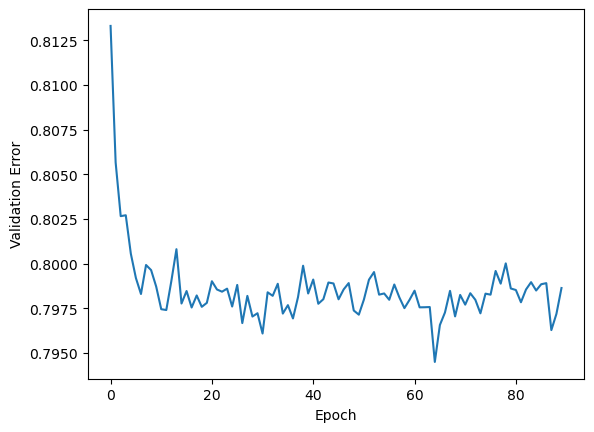

In [32]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

## Experiment Five - Recommender System using Matrix Factorization
### Three Latent Factor

In [33]:
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(10e-7), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(10e-7), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [34]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId, X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100


2538/2538 [==============================] - 1s 458us/step - loss: 11.9027 - val_loss: 7.3768
Epoch 2/100
2538/2538 [==============================] - 1s 435us/step - loss: 4.2323 - val_loss: 2.4713
Epoch 3/100
2538/2538 [==============================] - 1s 424us/step - loss: 1.7404 - val_loss: 1.3473
Epoch 4/100
2538/2538 [==============================] - 1s 423us/step - loss: 1.0702 - val_loss: 0.9956
Epoch 5/100
2538/2538 [==============================] - 1s 440us/step - loss: 0.8550 - val_loss: 0.8752
Epoch 6/100
2538/2538 [==============================] - 1s 429us/step - loss: 0.7824 - val_loss: 0.8317
Epoch 7/100
2538/2538 [==============================] - 1s 439us/step - loss: 0.7574 - val_loss: 0.8173
Epoch 8/100
2538/2538 [==============================] - 1s 421us/step - loss: 0.7486 - val_loss: 0.8111
Epoch 9/100
2538/2538 [==============================] - 1s 425us/step - loss: 0.7451 - val_loss: 0.8054
Epoch 10/100
2538/2538 [==============================] - 1s 425us

Minimum MSE: 0.763


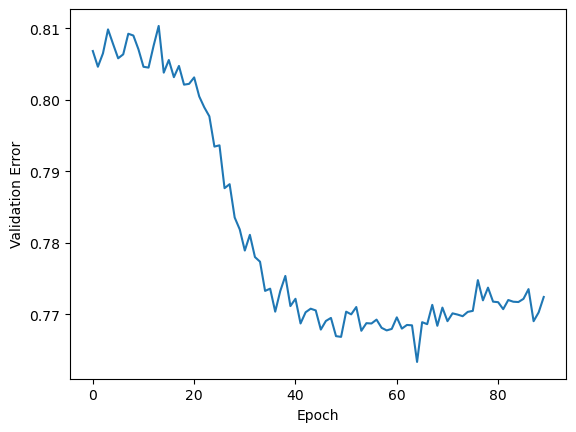

In [35]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

## Experiment Six - Recommender System using Matrix Factorization
### Five Latent Factors

In [36]:
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, 
                           output_dim=n_latent_factors, 
                           embeddings_regularizer=regularizers.l1(1e-6), 
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, 
                            output_dim=n_latent_factors, 
                            embeddings_regularizer=regularizers.l1(1e-6), 
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [37]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], 
                    y=X_train.rating, epochs=100, 
                    validation_data=([X_valid.newUserId,X_valid.newMovieId], X_valid.rating), 
                    verbose=1)

Epoch 1/100
2538/2538 [==============================] - 1s 455us/step - loss: 11.7663 - val_loss: 6.3335
Epoch 2/100
2538/2538 [==============================] - 1s 430us/step - loss: 3.2600 - val_loss: 1.8100
Epoch 3/100
2538/2538 [==============================] - 1s 441us/step - loss: 1.2868 - val_loss: 1.0579
Epoch 4/100
2538/2538 [==============================] - 1s 430us/step - loss: 0.8836 - val_loss: 0.8772
Epoch 5/100
2538/2538 [==============================] - 1s 430us/step - loss: 0.7841 - val_loss: 0.8295
Epoch 6/100
2538/2538 [==============================] - 1s 441us/step - loss: 0.7573 - val_loss: 0.8153
Epoch 7/100
2538/2538 [==============================] - 1s 429us/step - loss: 0.7492 - val_loss: 0.8115
Epoch 8/100
2538/2538 [==============================] - 1s 431us/step - loss: 0.7457 - val_loss: 0.8081
Epoch 9/100
2538/2538 [==============================] - 1s 439us/step - loss: 0.7431 - val_loss: 0.8014
Epoch 10/100
2538/2538 [==============================

Minimum MSE: 0.763


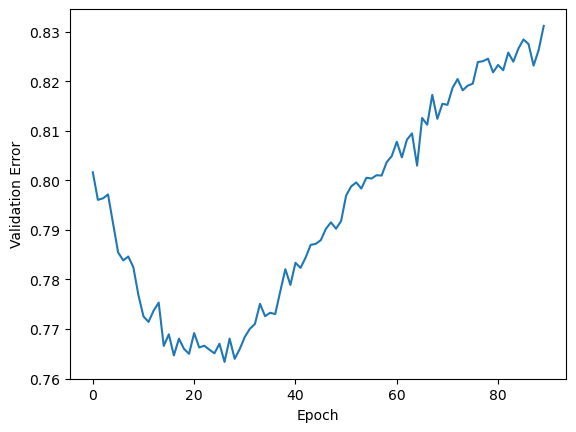

In [38]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print(f"Minimum MSE: {round(min(history.history['val_loss']),3)}")

## Experiment Seven - Recommender System using RBMs

In [39]:
# Make code compatible with v1 of TF
tf.compat.v1.disable_eager_execution()

In [40]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.compat.v1.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.compat.v1.placeholder(tf.float32, [self._output_size])
        _vb = tf.compat.v1.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.compat.v1.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.cast(tf.shape(v0)[0], tf.float32)
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.compat.v1.Session() as sess:
            sess.run(tf.compat.v1.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

## Begin the training cycle

In [41]:
# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [42]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

2024-01-10 01:30:12.186267: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Epoch: 0 reconstruction error: 1.110458
Epoch: 1 reconstruction error: 1.080464
Epoch: 2 reconstruction error: 1.090266
Epoch: 3 reconstruction error: 1.091606
Epoch: 4 reconstruction error: 1.094934
Epoch: 5 reconstruction error: 1.094252
Epoch: 6 reconstruction error: 1.091614
Epoch: 7 reconstruction error: 1.091776
Epoch: 8 reconstruction error: 1.097705
Epoch: 9 reconstruction error: 1.083840
Epoch: 10 reconstruction error: 1.091836
Epoch: 11 reconstruction error: 1.093464
Epoch: 12 reconstruction error: 1.086305
Epoch: 13 reconstruction error: 1.093750
Epoch: 14 reconstruction error: 1.092810
Epoch: 15 reconstruction error: 1.093246
Epoch: 16 reconstruction error: 1.089532
Epoch: 17 reconstruction error: 1.092540
Epoch: 18 reconstruction error: 1.095031
Epoch: 19 reconstruction error: 1.094005
Epoch: 20 reconstruction error: 1.090356
Epoch: 21 reconstruction error: 1.099656
Epoch: 22 reconstruction error: 1.092268
Epoch: 23 reconstruction error: 1.096907
Epoch: 24 reconstruction e

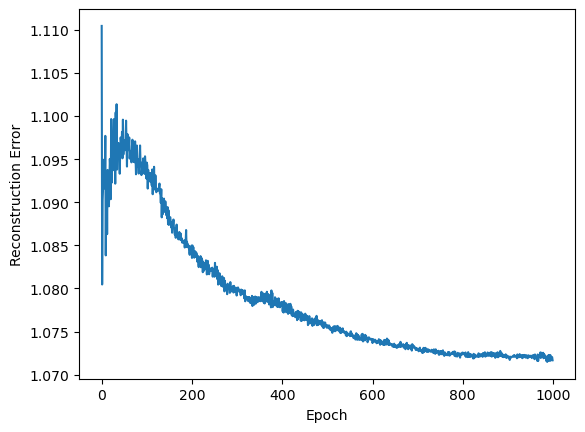

In [43]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error");

In [44]:
# Predict ratings for validation set
inputValid = ratings_valid
inputValid = inputValid.astype(np.float32)

_, reconstructedOutput_valid, _ = rbm.rbm_output(inputValid)

In [45]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_valid
pred_valid = predictionsArray[ratings_valid.nonzero()].flatten()
actual_valid = ratings_valid[ratings_valid.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_valid, actual_valid)
print(f'Mean squared error using RBM prediction: {round(rbm_prediction,2)}')

Mean squared error using RBM prediction: 9.34


# Conclusion

In [46]:
import datetime as dt
print("Completed: ", dt.datetime.now())

Completed:  2024-01-10 01:32:01.517755
